## Dynamical Friction

When an object of mass MS (“subject mass”) moves through a large collisionless system whose contituent particles (“field particles”) have mass $m \ll M_s$, it experiences a drag force, called dynamical friction. Essa tramuta l'energia cinetica di $M_s$ in energia cinetica randomica delle $m$. Così facendo guida l'evoluzione orbitale non solo di galassie satellite, ma anche di buchi neri, ammassi globulari vicini ai centri galattici e le barre di spirali barrate. 

\
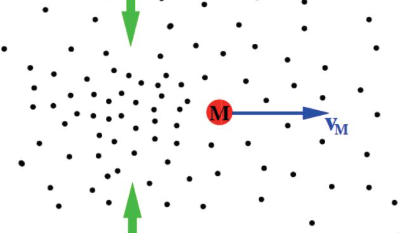



Nel caso di masse puntiformi, autogravità del campo di particelle trascurabile e se le particelle hanno una distribuzione di velocità isotropa (infinite homogeneous background), \
la forza di attrito dinamica a cui è soggetto il corpo $M_s$ è data dalla **Formula di Chandrasekhar**
$$ \vec{F}_\mathrm{df} = M_s \frac{d\vec{v}_s}{dt} = -4 \pi \bigg(\frac{G M_s}{v_s} \bigg)^2 \ln(\Lambda) \rho(<v_s) \frac{\vec{v}_s}{v_s}   $$  


$$\Lambda \approx \frac{b_\mathrm{max}}{b_\mathrm{90}} \quad\quad b_\mathrm{max} \sim R  \quad\quad  b_\mathrm{90} \sim \frac{G M_s}{v_\mathrm{rms}}$$


A differenza dell'attrito idrodinamico se $M_s$ è lento $F_\mathrm{df} \propto v_s$, se $M_s$ è veloce $F_\mathrm{df} \propto v_s^{-2}$. \
In più $F_\mathrm{df} \propto M_s^2$ per il doppio effetto sul wake.

In [1]:
# %matplotlib widget
import numpy as np 
import matplotlib.pyplot as plt
import rebound  

%matplotlib widget

In [2]:
sim = rebound.Simulation()
sim.widget(port=4321,size=(1000,1000))


boxL = 10
nx, ny = 10, 5
sim.configure_box(boxL,nx,ny)

sim.boundary = "open"
sim.gravity = "tree"
sim.integrator = "leapfrog"
sim.softening = 1
sim.opening_angle2 = 1.5
np.random.seed(0)
M = 100 # massa tot particelle
N = 1000
m = 100 # massa BH
T = 2
# più cresce M, o N, o Vx, o diminuisce mBH o vBH
# ovvero più il momento è dominato da quello della particelle
# più rispetto al centro di massa si muove veloce BH
# quindi più stelle sono più lente di lui ovvero rho(<vs)

Vx = 10 # vel BH
nrows = 10
ncols = int(N/nrows)
k = 0
xs = np.linspace(-nx*boxL/2,nx*boxL/2,ncols)
ys = np.linspace(-ny*boxL/2*0.9,ny*boxL/2*0.9,nrows)
for x in xs:
    for y in ys:
        vx = -2*Vx
        sim.add(m=M/N,x=x,y=y,vx=vx,r=boxL/50)

sim.add(m=m,x=boxL*(nx-1)/nx,y=0,vx=0,vy=0,hash="BH",r=boxL/10)
sim.collision = "none"
steps = int(1e4)
# v = np.zeros(steps)
# theta = np.zeros(steps)

x_BH = []
v_BH = []
theta = 0
i = 0
Nparticles = sim.N
k = 0
cycle = 0
# dt = sim.dt

def heartbeat(sim_pointer):
    global x_BH,v_BH, theta, i, Nparticles, k, cycle
    sim = sim_pointer.contents
    t = sim.t
    # dt = boxL**3/(N-1)/(2*Vx)
    dt = boxL*nx/ncols/(2*Vx)
    if np.floor(t/dt)>cycle:
        cycle += 1
        x = nx*boxL/2
        ys = np.linspace(-ny*boxL/2*0.9,ny*boxL/2*0.9,nrows)
        vx = -2*Vx
        for y in ys:
            sim.add(m=M/N,x=x,y=y,vx=vx,r=boxL/50)
        t = 0

        Nparticles = sim.N
    
    v_BH = np.append(v_BH,sim.particles["BH"].vx)
    x_BH = np.append(x_BH,sim.particles["BH"].x)
    i+=1

sim.heartbeat = heartbeat

4001 4001


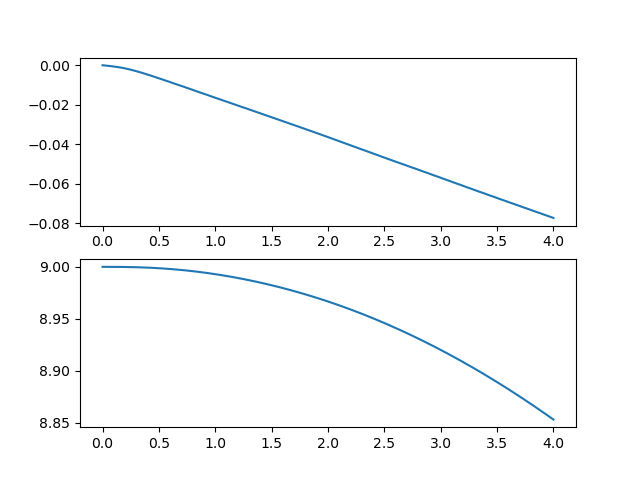

In [3]:
plt.close()
fig, ax = plt.subplots(nrows=2,ncols=1)

sim.integrate(T*2)
# sim.steps(steps)

ts = np.linspace(0,T*2,len(v_BH))
ax[0].plot(ts,v_BH)
ax[1].plot(ts,x_BH)

print(len(v_BH),len(ts))
plt.show()

In [4]:
# Aggiungo l'andamento teorico dalla formula di Chandrasekhar
v_squared = 0
v_squares_summed = 0
slower_particles = 0

for i in range(sim.N):
    v_squared = sim.particles[i].vx**2+sim.particles[i].vy**2+sim.particles[i].vz**2
    v_squares_summed += v_squared
    if v_squared*M < Vx**2*m:
        slower_particles += 1


v_rms = np.sqrt(v_squared/N)
print(v_rms)

b_90 = sim.G*M/v_rms
b_max = boxL
Λ = b_max/b_90
print(f"Lambda: {Λ:.2f}\nv_rms: {v_rms:2f}\nslower_particles: {slower_particles:.2f}")

t_cross = boxL*2/Vx
t_relax = 0.1*N/np.log(N) * t_cross
t_sim = 2

# Calcolo la densità di particelle con velocità assoluta minore di quella del BH
rho = M/((boxL*nx)*(boxL*ny)) # surf density
rho_vs = rho**slower_particles
 
ax_df = -4*np.pi*((sim.G)/Vx)**2*m*np.log(Λ)*rho_vs
print(rf"ax_df: {ax_df:.2e}")

0.6324555320336759
Lambda: 0.06
v_rms: 0.632456
slower_particles: 1.00
ax_df: 6.94e-01


In [5]:
sim.integrate(T*4)

In [6]:
# print(len(ts))
# ts2 = np.linspace(T*2,T*4,len(v_BH[len(ts)-1:-1]))
# print(len(ts2))
# print(len(v_BH))
# print(len(ts)+len(ts2))
# print(len(v_BH[len(ts)-1:-1]))
# # print(len(v_BH))
# # ts = np.linspace(0,T*4,len(v_BH))
# # print(len(ts))
# ax[0].plot(ts2,(v_BH[int(len(ts))-1]-ts2*ax_df)/10,'r--')
# plt.show()